Портированное при помощи ChatGPT с JAX на PyTorch решения уравнения Аллена-Кана из статьи: "Sifan Wang, Shyam Sankaran. Respecting causality is all you need for training physics-informed neural networks"
Ссылка на блокнот: https://github.com/PredictiveIntelligenceLab/CausalPINNs/blob/main/Allen_Cahn/AC.ipynb

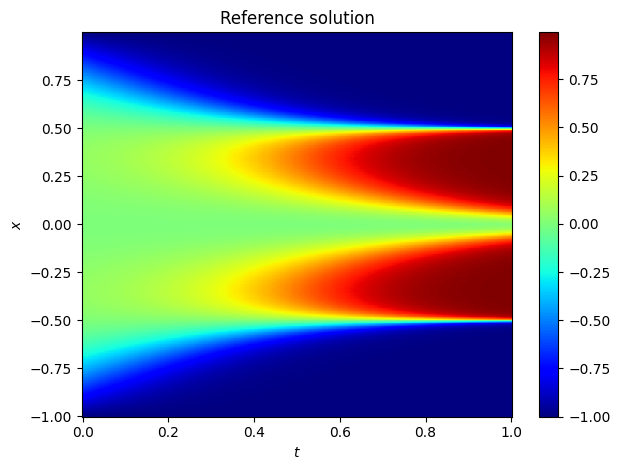

  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3000/3000 [01:41<00:00, 29.51it/s, Loss=0.000184, loss_ics=3.96e-7, loss_res=1.59]


Relative L2 error: 7.167e-01


In [11]:
from pathlib import Path

import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad as torch_grad

# ============================================================
# Periodic MLP (with Fourier features in x)
# ============================================================

class PeriodicMLP(nn.Module):
    def __init__(self, layers, L=2.0, M=10, activation=torch.tanh):
        """
        layers: list of layer sizes, e.g. [d_in, 128, 128, ..., 1]
        L: spatial period (here 2.0 for x ∈ [-1, 1])
        M: number of Fourier modes
        """
        super().__init__()
        self.L = L
        self.M = M
        self.activation = activation

        linears = []
        for d_in, d_out in zip(layers[:-1], layers[1:]):
            linear = nn.Linear(d_in, d_out)
            # Glorot-style init: std = sqrt(2 / (d_in + d_out))
            std = np.sqrt(2.0 / (d_in + d_out))
            nn.init.normal_(linear.weight, mean=0.0, std=std)
            nn.init.zeros_(linear.bias)
            linears.append(linear)

        self.layers = nn.ModuleList(linears)

    def input_encoding(self, t, x):
        """
        t, x: (N, 1) tensors
        returns: encoded features (N, 2 + 2M)
        """
        w = 2.0 * np.pi / self.L
        # k: (1, M)
        k = torch.arange(1, self.M + 1, device=t.device, dtype=t.dtype).view(1, -1)

        # Broadcast x: (N,1) -> (N,M)
        kx = k * w * x  # (N, M)
        cos_part = torch.cos(kx)
        sin_part = torch.sin(kx)

        ones = torch.ones_like(t)
        H = torch.cat([t, ones, cos_part, sin_part], dim=1)
        return H

    def forward(self, t, x):
        """
        t, x can be (N,) or (N,1); returns u(t,x) with shape (N,1)
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)
        if x.dim() == 1:
            x = x.unsqueeze(-1)

        H = self.input_encoding(t, x)
        for layer in self.layers[:-1]:
            H = self.activation(layer(H))
        out = self.layers[-1](H)
        return out  # (N,1)


# ============================================================
# PINN model (Allen–Cahn)
# ============================================================

class PINN:
    def __init__(self, layers, M, state0, t0, t1, n_t, n_x, tol,
                 x_star, nu, device=None):

        """
        layers: network layer sizes (input dim is 2 + 2*M)
        M: number of Fourier modes used in the encoder
        state0: numpy array (n_x, 1) with u(x, t=0)
        t0, t1: time interval for collocation
        n_t, n_x: number of collocation points in t and x
        tol: temporal weighting hyperparameter
        x_star: numpy array of spatial points used for IC (same as in data)
        nu: diffusion coefficient
        """

        self.device = device or torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.t0 = t0
        self.t1 = t1
        self.nu = nu
        self.tol = tol

        # Collocation grid in (t,x)
        self.t_r = torch.linspace(t0, t1, n_t, device=self.device, dtype=torch.float32)
        self.x_r = torch.linspace(-1.0, 1.0, n_x, device=self.device, dtype=torch.float32)

        # Temporal weighting matrix M (strictly lower triangular of ones)
        # matches: np.triu(np.ones((n_t, n_t)), k=1).T
        self.M = torch.tril(torch.ones(n_t, n_t, device=self.device), diagonal=-1)

        # Initial condition points (t=0, x=x_star)
        x_star = x_star.reshape(-1, 1)
        t_ic = np.zeros_like(x_star)
        X_ic = np.hstack([t_ic, x_star])

        self.X_ic = torch.tensor(X_ic, dtype=torch.float32, device=self.device)
        self.Y_ic = torch.tensor(state0, dtype=torch.float32, device=self.device)

        # Split to t and x for IC
        self.t_ic = self.X_ic[:, 0:1]  # (n_x,1)
        self.x_ic = self.X_ic[:, 1:2]  # (n_x,1)

        # Network
        self.net = PeriodicMLP(layers, L=2.0, M=M).to(self.device)

        # Optimizer + LR schedule (approx JAX exponential_decay)
        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)
        # lr(k) ≈ 1e-3 * 0.9^(k/5000)
        gamma = 0.9 ** (1.0 / 5000.0)
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=gamma)

        # Logs
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.W_log = []
        self.L_t_log = []

    # ------------------------------------------
    # Loss components
    # ------------------------------------------

    def compute_all_losses(self):
        """
        Compute:
          - total loss
          - IC loss
          - residual loss
          - L_t (per-time residual)
          - W (temporal weights)
        """

        # ----- Initial condition loss -----
        u_ic = self.net(self.t_ic, self.x_ic)
        loss_ics = torch.mean((self.Y_ic - u_ic) ** 2)

        # ----- PDE residual loss -----
        n_t = self.t_r.numel()
        n_x = self.x_r.numel()

        T, X = torch.meshgrid(self.t_r, self.x_r, indexing='ij')  # (n_t, n_x)
        T_flat = T.reshape(-1, 1).detach().requires_grad_(True)
        X_flat = X.reshape(-1, 1).detach().requires_grad_(True)

        u = self.net(T_flat, X_flat)  # (n_t*n_x, 1)

        ones = torch.ones_like(u)

        # First derivatives
        u_t = torch_grad(u, T_flat, grad_outputs=ones,
                         create_graph=True, retain_graph=True)[0]
        u_x = torch_grad(u, X_flat, grad_outputs=ones,
                         create_graph=True, retain_graph=True)[0]

        # Second derivative in x
        u_xx = torch_grad(u_x, X_flat, grad_outputs=torch.ones_like(u_x),
                          create_graph=True, retain_graph=True)[0]

        # Allen–Cahn residual: u_t + 5 u^3 - 5 u - nu u_xx
        r = u_t + 5.0 * u ** 3 - 5.0 * u - self.nu * u_xx  # (N,1)

        # Reshape residual to (n_t, n_x)
        r_grid = r.view(n_t, n_x)
        r2 = r_grid ** 2

        # Per-time residual (mean over x)
        L_t = r2.mean(dim=1)  # (n_t,)
        loss_res = r2.mean()

        # Temporal weights W = exp(-tol * (M @ L_t)), but stop gradient through W
        W = torch.exp(-self.tol * (self.M @ L_t.detach()))

        # Total loss
        L0 = 100.0 * loss_ics
        loss = (W * L_t).mean() + L0

        return loss, loss_ics, loss_res, L_t, W

    # ------------------------------------------
    # Training loop
    # ------------------------------------------

    def train(self, nIter=10000):
        self.net.train()

        pbar = trange(nIter)
        for it in pbar:
            self.optimizer.zero_grad()

            loss, loss_ics, loss_res, L_t, W = self.compute_all_losses()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            if it % 1000 == 0:
                self.loss_log.append(loss.item())
                self.loss_ics_log.append(loss_ics.item())
                self.loss_res_log.append(loss_res.item())
                self.W_log.append(W.detach().cpu().numpy())
                self.L_t_log.append(L_t.detach().cpu().numpy())

                pbar.set_postfix({
                    'Loss': loss.item(),
                    'loss_ics': loss_ics.item(),
                    'loss_res': loss_res.item()
                })

    # ------------------------------------------
    # Utilities
    # ------------------------------------------

    def predict_on_grid(self, t_star, x_star):
        """
        Evaluate u(t,x) on the full (x,t) grid defined by t_star, x_star.

        Returns:
            u_pred: numpy array of shape (len(x_star), len(t_star))
                    matching the shape of usol in your original code.
        """
        self.net.eval()

        # Build the same mesh as in the original script:
        # TT, XX = np.meshgrid(t_star, x_star)
        TT, XX = np.meshgrid(t_star, x_star)   # TT,XX: (n_x, n_t)

        TT_t = torch.tensor(TT, dtype=torch.float32, device=self.device)
        XX_t = torch.tensor(XX, dtype=torch.float32, device=self.device)

        with torch.no_grad():
            u_pred_flat = self.net(TT_t.reshape(-1, 1), XX_t.reshape(-1, 1))
        u_pred = u_pred_flat.view(TT.shape[0], TT.shape[1])  # (n_x, n_t)

        return u_pred.cpu().numpy()

    def compute_Lt_and_W(self):
        """
        Recompute L_t and W (for plotting) with current parameters.
        """
        self.net.eval()
        # We need gradients w.r.t. inputs here, so DO NOT use torch.no_grad()
        with torch.enable_grad():
            loss, loss_ics, loss_res, L_t, W = self.compute_all_losses()
        return (L_t.detach().cpu().numpy(),
                W.detach().cpu().numpy())


# ============================================================
# Main script (mirrors your original JAX code)
# ============================================================

# --------------------------------------------------------
# Load data
# --------------------------------------------------------
data = scipy.io.loadmat(Path.cwd() / 'data' / 'allen_cahn_chatgpt_ported.mat')
usol = data["uu"]          # shape (n_x, n_t)
t_star = data["tt"][0]     # time vector
x_star = data["x"][0]      # space vector

TT, XX = np.meshgrid(t_star, x_star)

plt.figure()
plt.pcolor(TT, XX, usol, cmap="jet")
plt.colorbar()
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title("Reference solution")
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# Hyperparameters / model setup
# --------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(2008)

M = 10
d0 = 2 * M + 2
layers = [d0, 128, 128, 128, 128, 1]

nu = 1e-4
t0 = 0.0
t1 = 1.0
n_t = 100
n_x = 256
tol = 100.0

state0 = usol[:, 0:1]  # initial condition u(x, t=0), shape (n_x,1)

model = PINN(layers, M, state0, t0, t1, n_t, n_x, tol,
                x_star=x_star, nu=nu, device=device)

# --------------------------------------------------------
# Train
# --------------------------------------------------------
# NOTE: 300000 iterations with second-order derivatives
# can be quite heavy in PyTorch; start smaller to test.
#model.train(nIter=300000)
model.train(nIter=3000)

# --------------------------------------------------------
# Evaluate trained model
# --------------------------------------------------------
u_pred = model.predict_on_grid(t_star, x_star)
error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol)
print("Relative L2 error: {:.3e}".format(error))


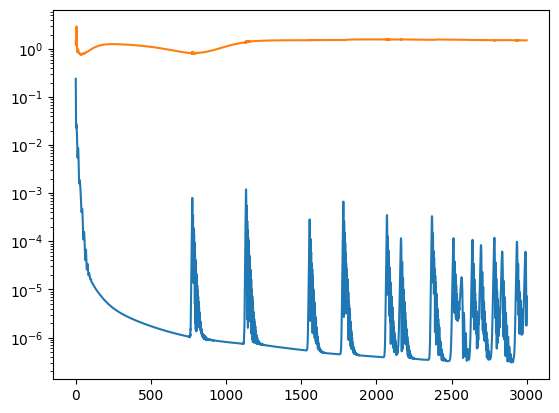

In [ ]:
plt.plot(model.loss_ics_log)
plt.plot(model.loss_res_log)
plt.yscale('log')

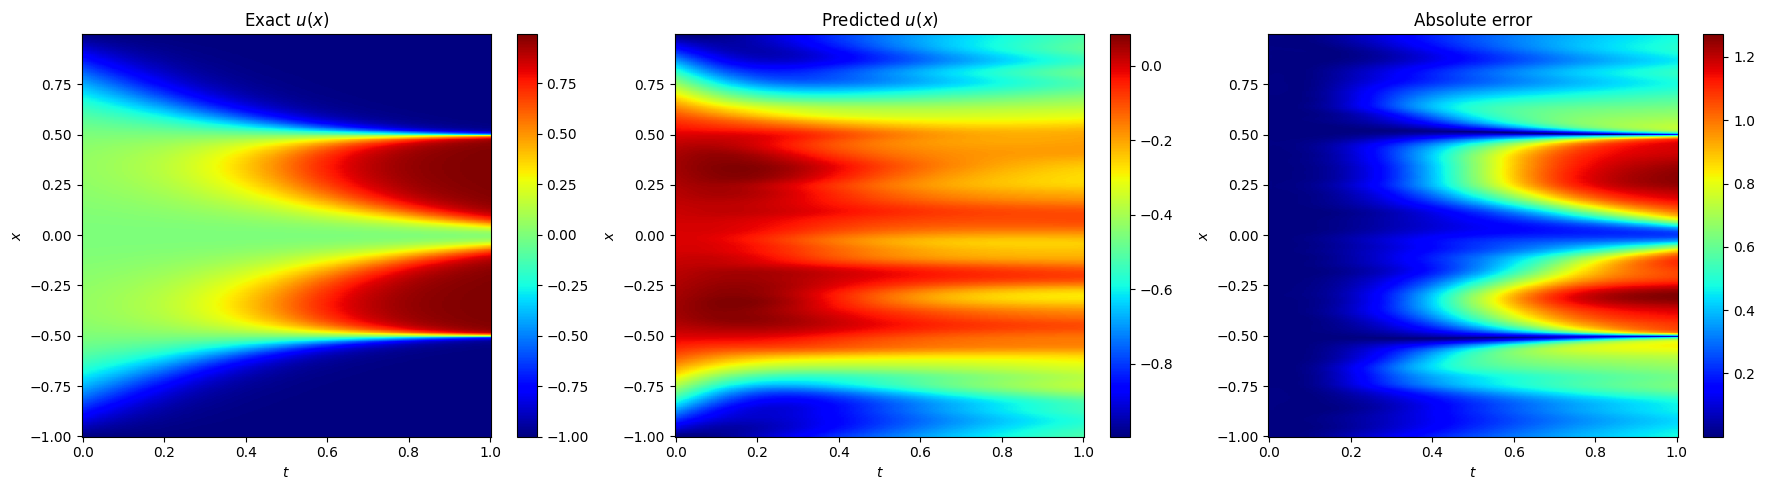

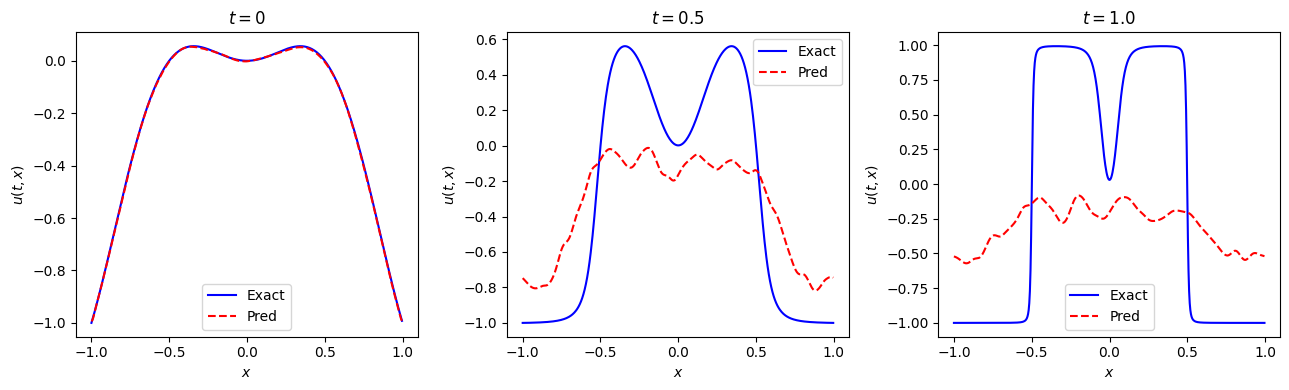

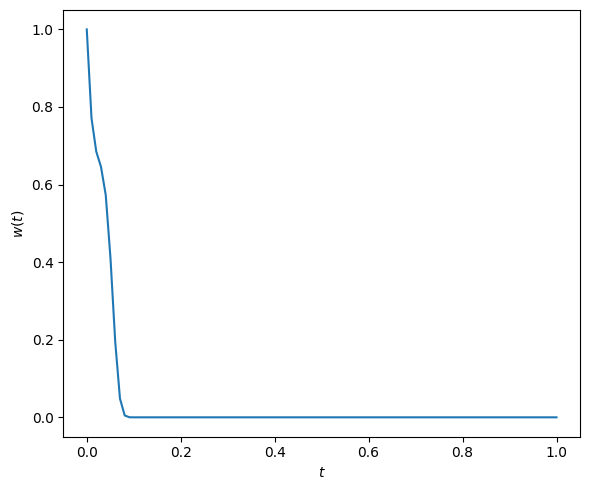

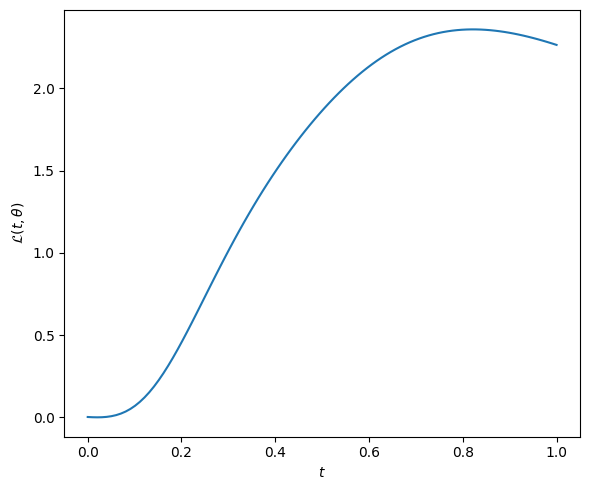

In [ ]:

# --------------------------------------------------------
# Plots: exact vs predicted vs error
# --------------------------------------------------------
fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap="jet")
plt.colorbar()
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(r"Exact $u(x)$")
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap="jet")
plt.colorbar()
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(r"Predicted $u(x)$")
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap="jet")
plt.colorbar()
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title("Absolute error")
plt.tight_layout()

plt.show()

# --------------------------------------------------------
# 1D slices at t = 0, 0.5, 1.0 (approx)
# --------------------------------------------------------
# Find indices closest to 0.0, 0.5, 1.0
def closest_idx(arr, val):
    return int(np.argmin(np.abs(arr - val)))

idx0 = closest_idx(t_star, 0.0)
idx05 = closest_idx(t_star, 0.5)
idx1 = closest_idx(t_star, 1.0)

fig = plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.plot(x_star, usol[:, idx0], color="blue", label="Exact")
plt.plot(x_star, u_pred[:, idx0], "--", color="red", label="Pred")
plt.xlabel("$x$")
plt.ylabel("$u(t, x)$")
plt.title("$t = 0$")
plt.legend()
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(x_star, usol[:, idx05], color="blue", label="Exact")
plt.plot(x_star, u_pred[:, idx05], "--", color="red", label="Pred")
plt.xlabel("$x$")
plt.ylabel("$u(t, x)$")
plt.title("$t = 0.5$")
plt.legend()
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(x_star, usol[:, idx1], color="blue", label="Exact")
plt.plot(x_star, u_pred[:, idx1], "--", color="red", label="Pred")
plt.xlabel("$x$")
plt.ylabel("$u(t, x)$")
plt.title("$t = 1.0$")
plt.legend()
plt.tight_layout()

plt.show()

# --------------------------------------------------------
# Temporal weights and per-time residuals
# --------------------------------------------------------
L_t, W = model.compute_Lt_and_W()

fig = plt.figure(figsize=(6, 5))
plt.plot(model.t_r.cpu().numpy(), W)
plt.xlabel("$t$")
plt.ylabel("$w(t)$")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 5))
plt.plot(model.t_r.cpu().numpy(), L_t)
plt.xlabel("$t$")
plt.ylabel(r"$\mathcal{L}(t, \theta)$")
plt.tight_layout()
plt.show()
